### TCAT Bus Schedule Optimization under Budget Constraints
- Supporting Codes

#### Model Formulation

In [11]:
!pip install datetime

In [11]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# Parameters
# ----------------------------
num_lines = 2
periods_len = 20
delta_t = periods_len / 60.0          # 20 minutes in hours
tstart = datetime(2025, 11, 24, 7, 0, 0)
tend   = datetime(2025, 11, 24, 19, 0, 0)
total_hours = int((tend - tstart).total_seconds() / 3600.0)
periods_per_hour = int(1 / delta_t)  # 6 periods per hour
num_times = total_hours * periods_per_hour  # total timesteps = 54
timesteps = pd.date_range(start=tstart, end=tend, freq=f"{periods_len}min")


# Costs and capacities
c = 75.0*delta_t                # $/bus-hour
w = 25.0*delta_t                # $/driver-hour
C = 40                          # passengers per bus
theta = 12.0                    # unmet-demand penalty $/passenger
price = 1.5                     # fare $/passenger
B_total = 2.5e6 / 365.0         # daily budget ($/day)
H = 18.0                        # max operating hours per bus per day
H_driver = 6 * 15                # total driver hours available
F_value = 3                    # fleet available per hour
F_inst = np.full(total_hours, F_value, dtype=int)  # per-hour fleet limit

# Trip duration per route (hours)
L_r = [16/60., 12/60.]

# Demand per 20-min timestep
u_line1 = [
  2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
 64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
 18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
 88, 129, 108, 16, 19, 14
]
u_line2 = [
   9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
  60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
  17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
  22,  16,  13,  14,  13,  12
]
demand = [u_line1, u_line2]

# Waiting-time saving coefficient
p1 = 5000
p2 = 8900
lambda_p1 = p1 * 0.12
lambda_p2 = p2 * 0.12
f1_ori = 12/60.   # original frequency in hours
f2_ori = 15/60.
f1_update = 10/60.
f2_update = 12/60.
beta1 = lambda_p1 * (f1_ori - f1_update)
beta2 = lambda_p2 * (f2_ori - f2_update)
beta = [beta1, beta2]

# Frequency requirement (trips per hour)
freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

# ----------------------------
# Create solver
# ----------------------------
solver = pywraplp.Solver.CreateSolver('CBC')
if not solver:
    raise Exception("CBC solver unavailable")

# ----------------------------
# Decision variables
# ----------------------------
X = {}  # number of buses on route r at timestep t
U = {}  # unmet demand
for r in range(num_lines):
    for t in range(num_times):
        X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
        U[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_{r}_{t}')

# ----------------------------
# Objective: minimize total cost
# ----------------------------
operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
unmet_cost = solver.Sum(U[r, t] * theta for r in range(num_lines) for t in range(num_times))
waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))

solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

# ----------------------------
# Constraints
# ----------------------------

# (A) Capacity vs demand
for r in range(num_lines):
    for t in range(num_times):
        solver.Add(C * X[r, t] + U[r, t] >= demand[r][t])

# (B) Fleet constraint per timestep (spread F_inst[h] across timestep)
for h in range(total_hours):
    start = h * periods_per_hour
    end = min((h+1) * periods_per_hour, num_times)
    for t in range(start, end):
        solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

# (C) Total bus-hours
solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= F_value * H)

# (D) Driver-hour capacity
solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= H_driver)

# (E) Budget
total_revenue = solver.Sum(price * (demand[r][t] - U[r, t]) for r in range(num_lines) for t in range(num_times))
solver.Add(operating_cost + labor_cost - total_revenue <= B_total)

# (F) Frequency constraint: enforce per hour
for r in range(num_lines):
    for h in range(total_hours):
        start = h * periods_per_hour
        end = min((h+1) * periods_per_hour, num_times)
        solver.Add(
            solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r]
        )
# ----------------------------
# Solve
# ----------------------------
status = solver.Solve()

# ----------------------------
# Output
# ----------------------------
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found.")
    print(f"Objective value = {solver.Objective().Value():.2f}")
    # schedule matrix
    schedule = [[int(X[r, t].solution_value()) for r in range(num_lines)] for t in range(num_times)]
    for t, row in enumerate(schedule):
        print(f"{timesteps[t]} | " + "  ".join(f"R{r+1}:{row[r]}" for r in range(num_lines)))
    # summary stats
    total_oper = sum(X[r, t].solution_value() * c * delta_t for r in range(num_lines) for t in range(num_times))
    total_labor = sum(X[r, t].solution_value() * w * delta_t for r in range(num_lines) for t in range(num_times))
    total_unmet = sum(U[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
    print(f"\nTotal operating cost = {total_oper:.2f}")
    print(f"Total labor cost = {total_labor:.2f}")
    print(f"Total unmet passengers = {total_unmet:.2f}")
else:
    print("No optimal solution found. Status:", status)


Optimal solution found.
Objective value = 7535.00
2025-11-24 07:00:00 | R1:2  R2:1
2025-11-24 07:20:00 | R1:1  R2:2
2025-11-24 07:40:00 | R1:1  R2:2
2025-11-24 08:00:00 | R1:2  R2:1
2025-11-24 08:20:00 | R1:0  R2:3
2025-11-24 08:40:00 | R1:2  R2:1
2025-11-24 09:00:00 | R1:2  R2:1
2025-11-24 09:20:00 | R1:2  R2:1
2025-11-24 09:40:00 | R1:2  R2:1
2025-11-24 10:00:00 | R1:1  R2:2
2025-11-24 10:20:00 | R1:2  R2:1
2025-11-24 10:40:00 | R1:2  R2:1
2025-11-24 11:00:00 | R1:2  R2:1
2025-11-24 11:20:00 | R1:1  R2:2
2025-11-24 11:40:00 | R1:1  R2:2
2025-11-24 12:00:00 | R1:0  R2:3
2025-11-24 12:20:00 | R1:2  R2:1
2025-11-24 12:40:00 | R1:2  R2:1
2025-11-24 13:00:00 | R1:0  R2:3
2025-11-24 13:20:00 | R1:2  R2:1
2025-11-24 13:40:00 | R1:2  R2:1
2025-11-24 14:00:00 | R1:1  R2:2
2025-11-24 14:20:00 | R1:2  R2:1
2025-11-24 14:40:00 | R1:1  R2:2
2025-11-24 15:00:00 | R1:1  R2:2
2025-11-24 15:20:00 | R1:2  R2:1
2025-11-24 15:40:00 | R1:1  R2:2
2025-11-24 16:00:00 | R1:1  R2:2
2025-11-24 16:20:00 | R1:2

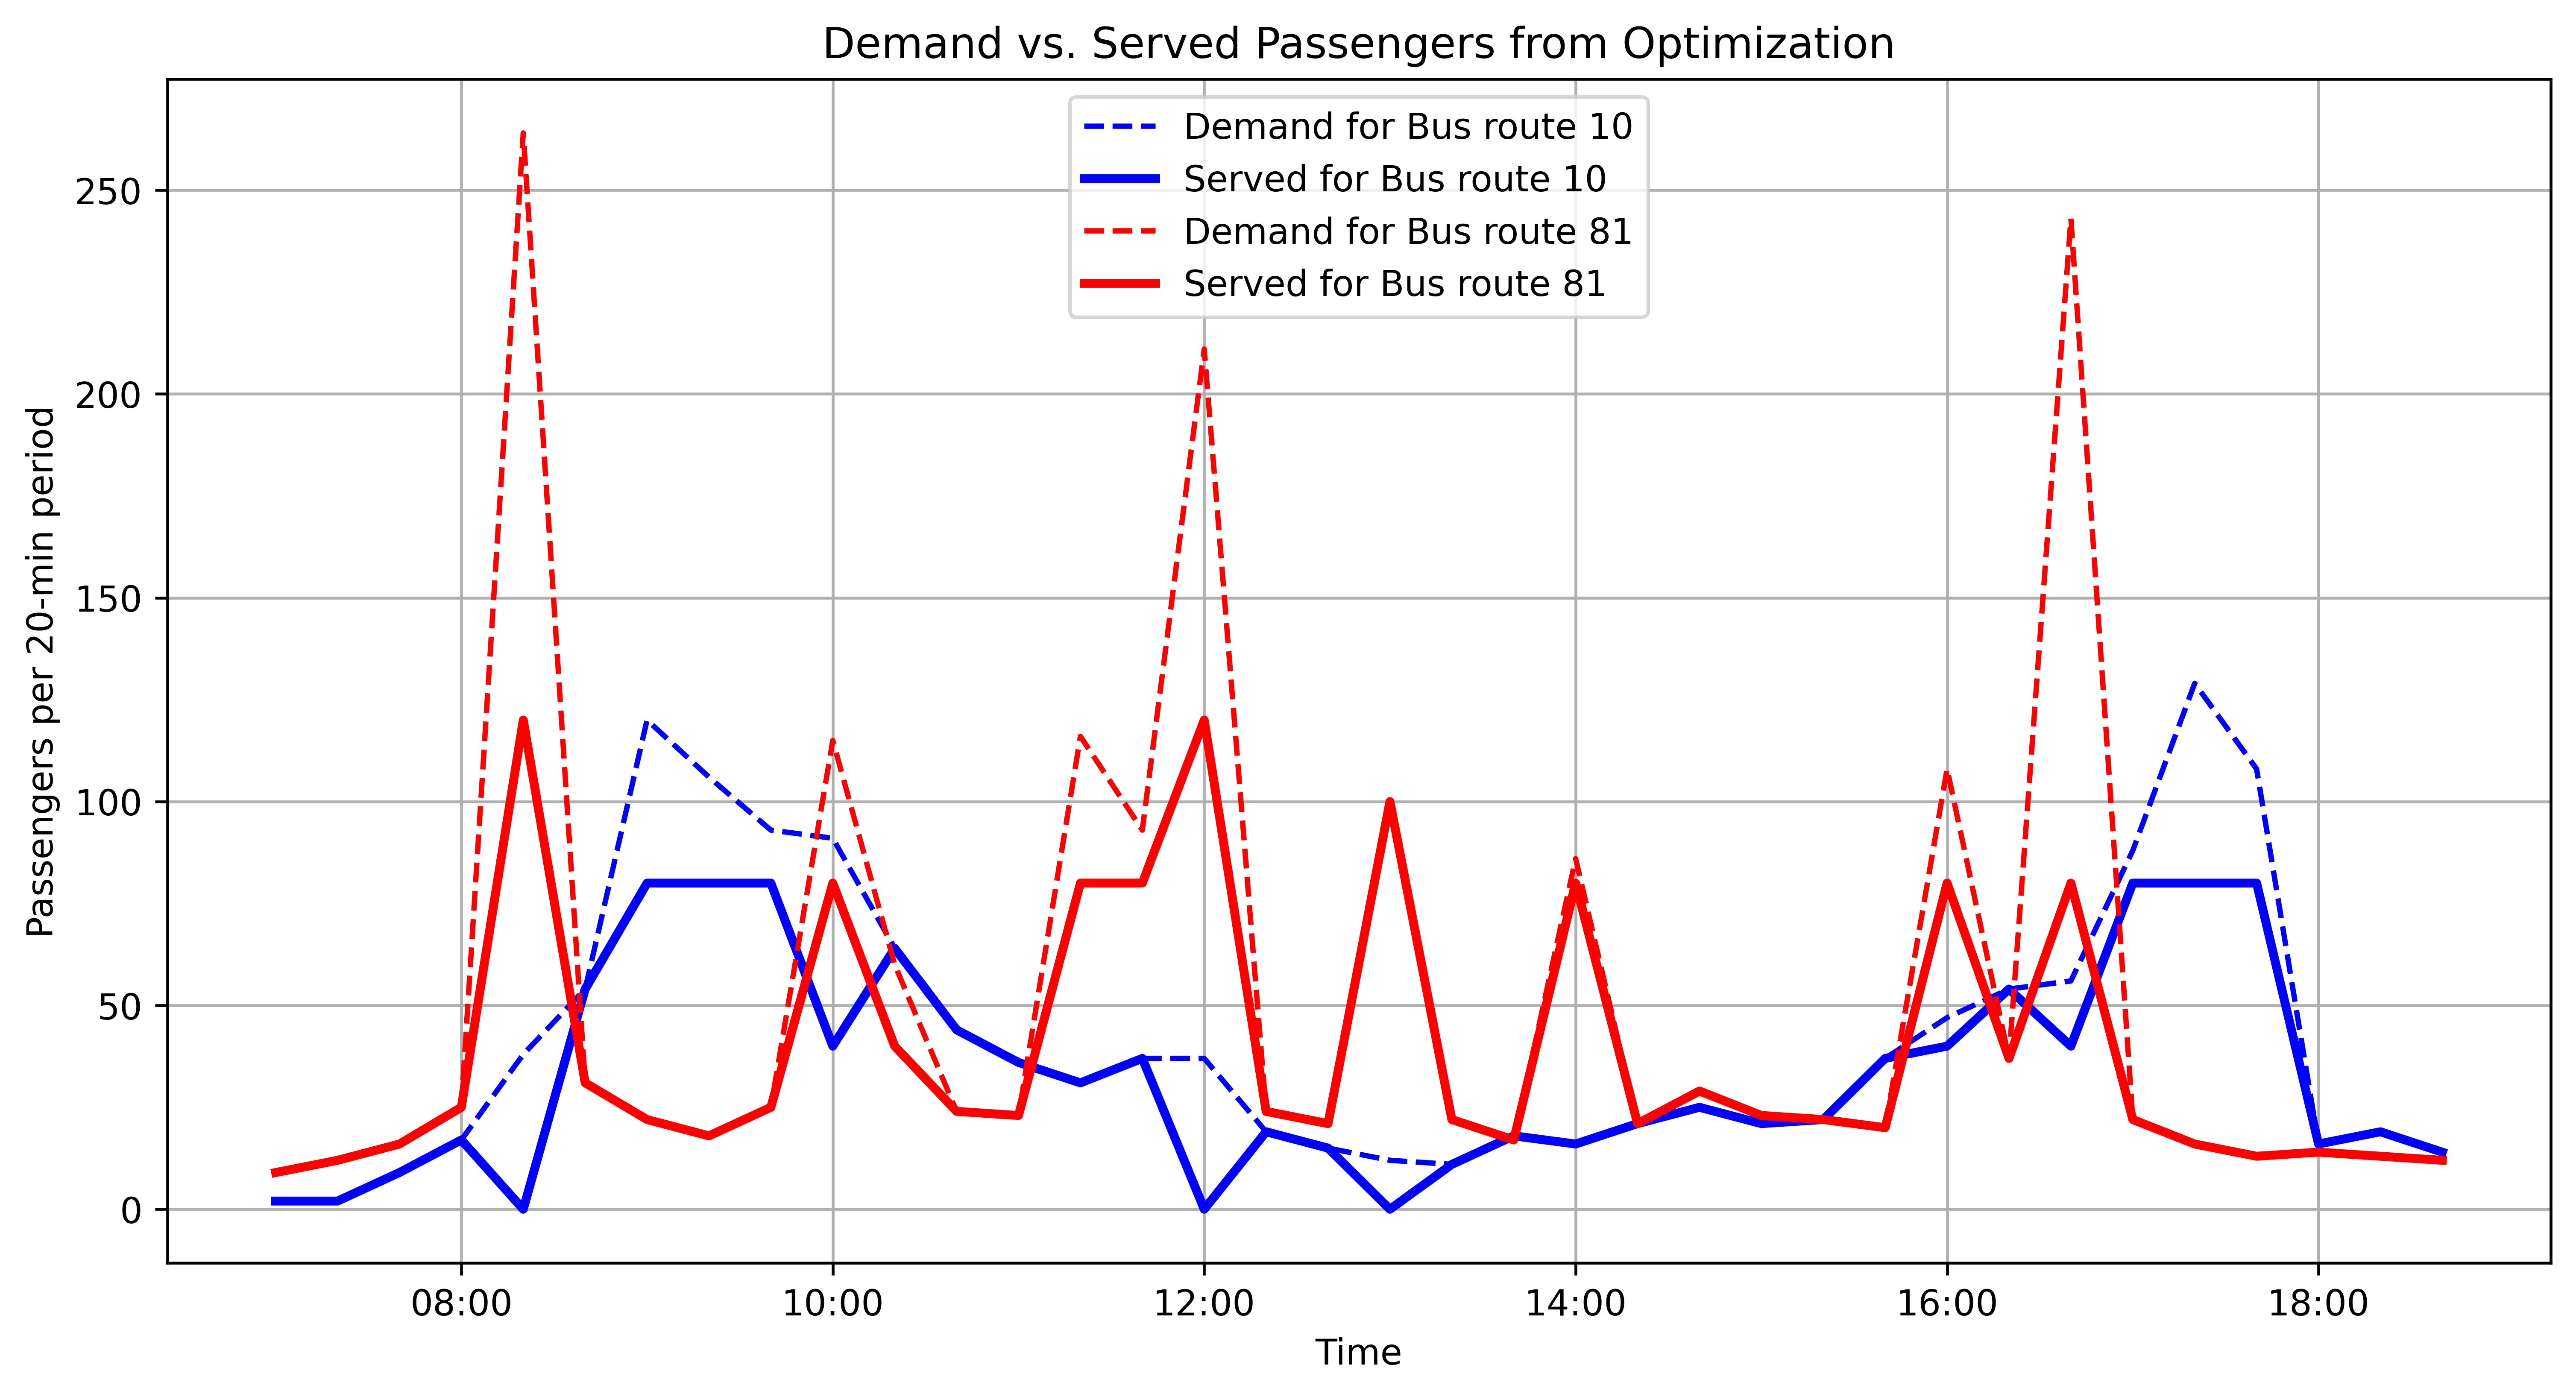

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
Bus_route_name = ['10', '81']
colors = ['blue','red']

# Build arrays for plotting
demand_array = np.array(demand)  # shape (num_lines, num_times)
served_array = np.zeros((num_lines, num_times))

for r in range(num_lines):
    for t in range(num_times):
        # Served passengers = demand - unmet demand
        served_array[r, t] = demand[r][t] - U[r, t].solution_value()

time_axis = timesteps[:-1]
# Plot each line
plt.figure(figsize=(12,6),dpi=600)
for r in range(num_lines):
    plt.plot(time_axis, demand_array[r], color=colors[r], label=f'Demand for Bus route {Bus_route_name[r]}', linestyle='--',lw=1.5)
    plt.plot(time_axis, served_array[r], color=colors[r], label=f'Served for Bus route {Bus_route_name[r]}',lw=2.5)

plt.xlabel('Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel(f'Passengers per {periods_len}-min period')
plt.title('Demand vs. Served Passengers from Optimization')
plt.legend()
plt.grid(True)
plt.show()


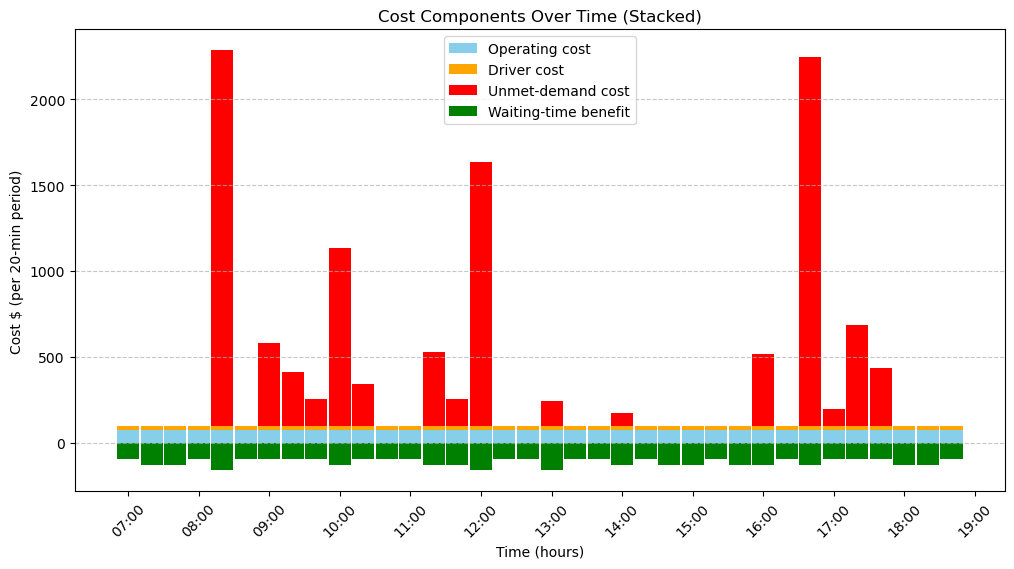

In [13]:
num_times = len(demand[0])
# Cost arrays per timestep
op_cost = np.zeros(num_times)
driver_cost = np.zeros(num_times)
wait_saving = np.zeros(num_times)
unmet_cost = np.zeros(num_times)

for t in range(num_times):
    for r in range(num_lines):
        x_val = X[r,t].solution_value()
        u_val = U[r,t].solution_value()
        op_cost[t] += c * x_val
        driver_cost[t] += w * x_val
        wait_saving[t] += beta[r] * x_val
        unmet_cost[t] += theta * u_val

# Stack cost components into a matrix for plotting
# We want positive numbers in the stack, so include waiting-time benefit as negative
total_positive_cost = np.vstack([op_cost, driver_cost, unmet_cost])
# We can optionally plot waiting-time savings as a separate color below zero
wait_saving_negative = -wait_saving  # make it positive for visualization below x-axis

# X-axis: time in hours
# time_axis = np.arange(num_times) * delta_t + 7.0

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12,6))
timesteps = pd.date_range(
    start=datetime(2025, 11, 24, 7, 0, 0),
    periods=num_times,
    freq=f"{periods_len}min"
)

ax.bar(time_axis, op_cost, width=0.013, label='Operating cost', color='skyblue', bottom=0)
ax.bar(time_axis, driver_cost, width=0.013, label='Driver cost', color='orange', bottom=op_cost)
ax.bar(time_axis, unmet_cost, width=0.013, label='Unmet-demand cost', color='red', bottom=op_cost+driver_cost)
# Plot waiting-time savings below x-axis
ax.bar(time_axis, -wait_saving, width=0.013, label='Waiting-time benefit', color='green')

ax.set_xlabel('Time (hours)')
ax.set_ylabel(f'Cost $ (per {periods_len}-min period)')
ax.set_title('Cost Components Over Time (Stacked)')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

plt.show()


### Analysis: Pareto Optimality
- Seek for trade-offs between **daily budget v. unmet demand**.
- Question: If TCAT could assign more daily budget to these routes, how much extra cost does TCAT need to spend to reduce the number of abandoned passengers to zero?

Running Pareto Analysis: Budget vs. Unmet Demand...
Budget: $1000  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $1250  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $1500  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $1750  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $2000  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $2250  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $2500  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $2750  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $3000  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $3250  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $3500  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $3750  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $4000  | Unmet Passengers: 861.0 | Actual Net Cost: $-2692.5
Budget: $4250  | Unmet Passengers: 861.0 | Actual N

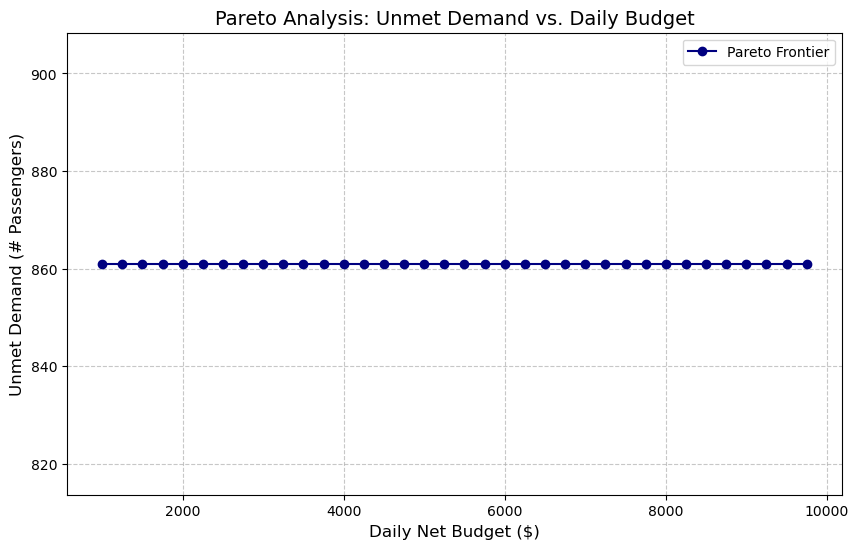

In [14]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# 1. Incorporate the Optimization Logic into a Function (from Yingying's model formulation)
def solve_bus_schedule(budget_limit):
    
    # Parameters
    num_lines = 2
    periods_len = 20
    delta_t = periods_len / 60.0
    tstart = datetime(2025, 11, 24, 7, 0, 0)
    tend   = datetime(2025, 11, 24, 19, 0, 0)
    total_hours = int((tend - tstart).total_seconds() / 3600.0)
    periods_per_hour = int(1 / delta_t)
    num_times = total_hours * periods_per_hour 
    
    # Costs and capacities
    c = 75.0 * delta_t          # $/bus-hour
    w = 25.0 * delta_t          # $/driver-hour
    C = 40                      # capacity
    theta = 12.0                # unmet-demand penalty
    price = 1.5                 # fare
        
    H = 18.0                    # max operating hours per bus
    H_driver = 6 * 15           # total driver hours
    F_value = 3                 # available fleet number
    F_inst = np.full(total_hours, F_value, dtype=int)

    L_r = [16/60., 12/60.] # Trip duration

    # Demand
    u_line1 = [
    2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
    64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
    18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
    88, 129, 108, 16, 19, 14
    ]
    u_line2 = [
    9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
    60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
    17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
    22,  16,  13,  14,  13,  12
    ]
    demand = [u_line1, u_line2]

    # Waiting-time coefficients
    p1, p2 = 5000, 8900
    lambda_p1 = p1 * 0.12
    lambda_p2 = p2 * 0.12
    f1_ori, f2_ori = 12/60., 15/60.
    f1_update, f2_update = 10/60., 12/60.
    beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
    freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

    # Solver
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver: return None, 0, 0, 0

    # Decision variables
    X = {}
    U = {}
    for r in range(num_lines):
        for t in range(num_times):
            X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
            U[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_{r}_{t}')

    # Objective terms
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    # Obj: Minimize Total Generalized Cost
    solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

    # Constraints
    
    # (A) Capacity vs Demand
    for r in range(num_lines):
        for t in range(num_times):
            solver.Add(C * X[r, t] + U[r, t] >= demand[r][t])

    # (B) Fleet Constraint
    for h in range(total_hours):
        start = h * periods_per_hour
        end = min((h+1) * periods_per_hour, num_times)
        for t in range(start, end):
            solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

    # (C & D) Bus & Driver Hours
    solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= F_value * H)
    solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= H_driver)

    # (E) Dynamic Budget Constraint
    # Net Cost = Ops + Labor - Revenue <= budget_limit
    total_revenue = solver.Sum(price * (demand[r][t] - U[r, t]) for r in range(num_lines) for t in range(num_times))
    solver.Add(operating_cost + labor_cost - total_revenue <= budget_limit)

    # (F) Frequency
    for r in range(num_lines):
        for h in range(total_hours):
            start = h * periods_per_hour
            end = min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    # Solve
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        # Calculate result metrics
        val_unmet = sum(U[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
        val_ops = sum(X[r, t].solution_value() * c * delta_t for r in range(num_lines) for t in range(num_times))
        val_lab = sum(X[r, t].solution_value() * w * delta_t for r in range(num_lines) for t in range(num_times))
        val_rev = sum(price * (demand[r][t] - U[r, t].solution_value()) for r in range(num_lines) for t in range(num_times))
        net_cost_val = val_ops + val_lab - val_rev
        return "OPTIMAL", solver.Objective().Value(), val_unmet, net_cost_val
    else:
        return "INFEASIBLE", 0, 0, 0

# 2. Pareto Analysis Loop
print("Running Pareto Analysis: Budget vs. Unmet Demand...")

# Define Budget Range
budgets = np.arange(1000, 10000, 250) 
results_budget = []
results_unmet = []

for b in budgets:
    status, obj, unmet, net_cost = solve_bus_schedule(b)
    
    if status == "OPTIMAL":
        results_budget.append(b)
        results_unmet.append(unmet)
        print(f"Budget: ${b:<5.0f} | Unmet Passengers: {unmet:.1f} | Actual Net Cost: ${net_cost:.1f}")
    else:
        print(f"Budget: ${b:<5.0f} | Infeasible (Budget too low to meet freq/safety constraints)")

# 3. Plot

if len(results_budget) > 0:
    plt.figure(figsize=(10, 6))
    
    # Plot the curve
    plt.plot(results_budget, results_unmet, marker='o', linestyle='-', color='navy', label='Pareto Frontier')
    
    plt.title('Pareto Analysis: Unmet Demand vs. Daily Budget', fontsize=14)
    plt.xlabel('Daily Net Budget ($)', fontsize=12)
    plt.ylabel('Unmet Demand (# Passengers)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
            
    plt.legend()
    plt.show()

#### Interpretation

Diminishing returns: The Pareto line flattens out and adding more budget does not significantly reduce unmet passengers. This indicates the system is not limited by budget. (Budget is not a true bottleneck here.)

Then, move onto the other Pareto analysis to find out the actual bottleneck for this optimization problem.
- Seek for trade-offs between **number of buses v. unmet demand**.
- Question: If TCAT could assign more number of buses to these two routes, how many would they need, for each route?
- Total number of fleets available v. Unmet demand (service gap)

Num Buses  | Op Cost ($)  | Unmet Demand
----------------------------------------
3          | 1200.00      | 861.00      
4          | 1600.00      | 431.00      
5          | 2000.00      | 260.00      
6          | 2400.00      | 132.00      
7          | 2800.00      | 43.00       
8          | 3200.00      | 3.00        
9          | 3600.00      | 0.00        
10         | 4000.00      | 0.00        
11         | 4400.00      | 0.00        
12         | 4800.00      | 0.00        
13         | 5200.00      | 0.00        
14         | 5600.00      | 0.00        
15         | 6000.00      | 0.00        


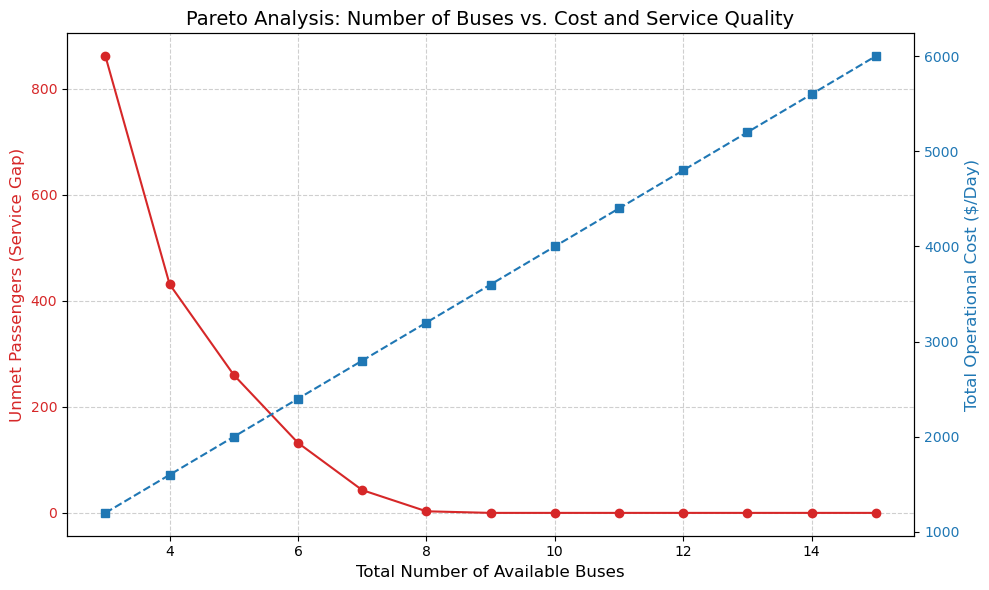

In [15]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def solve_bus_scenario(num_available_buses):
    
    # Parameters
    num_lines = 2
    periods_len = 20
    delta_t = periods_len / 60.0
    tstart = datetime(2025, 11, 24, 7, 0, 0)
    tend   = datetime(2025, 11, 24, 19, 0, 0)
    total_hours = int((tend - tstart).total_seconds() / 3600.0)
    periods_per_hour = int(1 / delta_t)
    num_times = total_hours * periods_per_hour 
    
    # Costs and capacities
    c = 75.0 * delta_t          
    w = 25.0 * delta_t          
    C = 40 # Capacity (passengers per bus)
    theta = 12.0                
    price = 1.5                 
    H = 18.0                    
    H_driver = 1000 # Large enough driver hours to focus on the bus constraint (this becomes 'limitation' of Pareto optimality solution as well)
    
    # Demand data
    u_line1 = [
    2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
    64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
    18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
    88, 129, 108, 16, 19, 14
    ]
    u_line2 = [
    9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
    60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
    17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
    22,  16,  13,  14,  13,  12
    ]
    demand = [u_line1, u_line2]
    
    # Frequency/Waiting
    L_r = [16/60., 12/60.]
    p1, p2 = 5000, 8900
    lambda_p1 = p1 * 0.12
    lambda_p2 = p2 * 0.12
    f1_ori, f2_ori = 12/60., 15/60.
    f1_update, f2_update = 10/60., 12/60.
    beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
    freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

    solver = pywraplp.Solver.CreateSolver('CBC')

    # Decision variables
    X = {}
    U = {}
    for r in range(num_lines):
        for t in range(num_times):
            # X[r, t] is constrained by the loop variable num_available_buses
            X[r, t] = solver.IntVar(0, num_available_buses, f'X_{r}_{t}')
            U[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_{r}_{t}')

    # Objective terms
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    # Obj: Minimize Total Generalized Cost
    solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

    # Constraints
    # (A) Capacity vs Demand
    for r in range(num_lines):
        for t in range(num_times):
            solver.Add(C * X[r, t] + U[r, t] >= demand[r][t])

    # (B) Total Number of Buses Constraint: The SUM of buses deployed cannot exceed the total available
    for t in range(num_times):
        # Ensure that the sum of buses across all routes (r) at any time (t) is <= num_available_buses
        solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= num_available_buses)

    # (C) Driver Hours (Relaxed)
    solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= H_driver)

    # (D) Frequency (F)
    for r in range(num_lines):
        for h in range(total_hours):
            start = h * periods_per_hour
            end = min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        val_unmet = sum(U[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
        # Actual Operational Cost (Op + Labor)
        actual_cash_cost = sum((c+w)*delta_t * X[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
        return actual_cash_cost, val_unmet
    else:
        return None, None

# Run Pareto Analysis
num_buses_range = range(3, 16) # Test number of available buses from 3 to 15
costs = []
unmet_demands = []
valid_buses = []

print(f"{'Num Buses':<10} | {'Op Cost ($)':<12} | {'Unmet Demand':<12}")
print("-" * 40)

for n in num_buses_range:
    cost, unmet = solve_bus_scenario(n)
    if cost is not None:
        valid_buses.append(n)
        costs.append(cost)
        unmet_demands.append(unmet)
        print(f"{n:<10} | {cost:<12.2f} | {unmet:<12.2f}")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Total Number of Available Buses', fontsize=12)
ax1.set_ylabel('Unmet Passengers (Service Gap)', color=color, fontsize=12)
ax1.plot(valid_buses, unmet_demands, color=color, marker='o', linestyle='-', label='Unmet Demand')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total Operational Cost ($/Day)', color=color, fontsize=12)  
ax2.plot(valid_buses, costs, color=color, marker='s', linestyle='--', label='Op Cost')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Pareto Analysis: Number of Buses vs. Cost and Service Quality', fontsize=14)
fig.tight_layout()  
plt.show()

Now, look from the perspective of TCAT, whose objective is to maximize net financial result (revenue - cost).

Buses  | Served     | Revenue ($)  | Op Cost ($)  | Net Profit ($)
-----------------------------------------------------------------
3      | 2595       | 3892         | 1200         | 2692        
4      | 3025       | 4538         | 1600         | 2938        
5      | 3196       | 4794         | 2000         | 2794        
6      | 3324       | 4986         | 2400         | 2586        
7      | 3413       | 5120         | 2800         | 2320        
8      | 3453       | 5180         | 3200         | 1980        
9      | 3456       | 5184         | 3600         | 1584        
10     | 3456       | 5184         | 4000         | 1184        
11     | 3456       | 5184         | 4400         | 784         
12     | 3456       | 5184         | 4800         | 384         
13     | 3456       | 5184         | 5200         | -16         
14     | 3456       | 5184         | 5600         | -416        
15     | 3456       | 5184         | 6000         | -816        


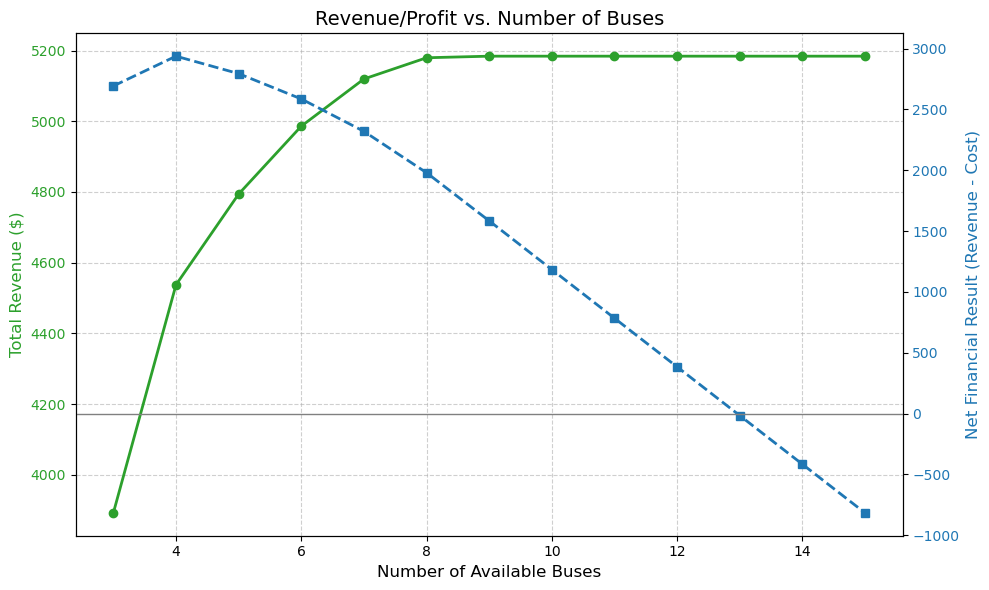

In [16]:
from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def solve_financial_scenario(num_available_buses):
    # Parameters
    num_lines = 2
    periods_len = 20
    delta_t = periods_len / 60.0
    tstart = datetime(2025, 11, 24, 7, 0, 0)
    tend   = datetime(2025, 11, 24, 19, 0, 0)
    total_hours = int((tend - tstart).total_seconds() / 3600.0)
    periods_per_hour = int(1 / delta_t)
    num_times = total_hours * periods_per_hour 
    
    # Costs and capacities
    c = 75.0 * delta_t          
    w = 25.0 * delta_t          
    C = 40                      
    theta = 12.0                
    price = 1.5  # Fare per passenger               
    H_driver = 1000 
    
    # Demand data
    u_line1 = [
    2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
    64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
    18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
    88, 129, 108, 16, 19, 14
    ]
    u_line2 = [
    9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
    60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
    17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
    22,  16,  13,  14,  13,  12
    ]
    demand = [u_line1, u_line2]
    # Calculate Total Potential Demand
    total_potential_demand = sum(sum(line) for line in demand)

    # Frequency/Waiting parameters
    L_r = [16/60., 12/60.]
    p1, p2 = 5000, 8900
    lambda_p1 = p1 * 0.12
    lambda_p2 = p2 * 0.12
    f1_ori, f2_ori = 12/60., 15/60.
    f1_update, f2_update = 10/60., 12/60.
    beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
    freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

    solver = pywraplp.Solver.CreateSolver('CBC')

    # Decision variables
    X = {}
    U = {}
    for r in range(num_lines):
        for t in range(num_times):
            X[r, t] = solver.IntVar(0, num_available_buses, f'X_{r}_{t}')
            U[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_{r}_{t}')

    # Objective terms and function
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

    # Constraints
    for r in range(num_lines):
        for t in range(num_times):
            solver.Add(C * X[r, t] + U[r, t] >= demand[r][t])

    for t in range(num_times):
        solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= num_available_buses)

    solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= H_driver)

    for r in range(num_lines):
        for h in range(total_hours):
            start = h * periods_per_hour
            end = min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        val_unmet = sum(U[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
        val_served = total_potential_demand - val_unmet
        # Actual Cash Cost (Operating + Labor)
        val_ops_cost = sum((c+w)*delta_t * X[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
        val_revenue = val_served * price
        
        return {
            "buses": num_available_buses,
            "passengers_served": val_served,
            "revenue": val_revenue,
            "operational_cost": val_ops_cost, # Operating + Labor
            "net_financial": val_revenue - val_ops_cost
        }
    else:
        return None

# Run Analysis Loop
results = []
print(f"{'Buses':<6} | {'Served':<10} | {'Revenue ($)':<12} | {'Op Cost ($)':<12} | {'Net Profit ($)':<12}")
print("-" * 65)

for b in range(3, 16):
    res = solve_financial_scenario(b)
    if res:
        results.append(res)
        print(f"{res['buses']:<6} | {res['passengers_served']:<10.0f} | {res['revenue']:<12.0f} | {res['operational_cost']:<12.0f} | {res['net_financial']:<12.0f}")

df = pd.DataFrame(results)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Revenue (Green)
color1 = 'tab:green'
ax1.set_xlabel('Number of Available Buses', fontsize=12)
ax1.set_ylabel('Total Revenue ($)', color=color1, fontsize=12)
ax1.plot(df['buses'], df['revenue'], color=color1, marker='o', linewidth=2, label='Total Revenue')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot Net Profit (Blue)
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Net Financial Result (Revenue - Cost)', color=color2, fontsize=12)
ax2.plot(df['buses'], df['net_financial'], color=color2, marker='s', linestyle='--', linewidth=2, label='Net Profit')
ax2.tick_params(axis='y', labelcolor=color2)

# Add a reference line for Break-Even if applicable
ax2.axhline(0, color='gray', linewidth=1, linestyle='-')

plt.title('Revenue/Profit vs. Number of Buses', fontsize=14)
fig.tight_layout()
plt.show()

#### Post-Pareto Analysis: Re-run the Optimization Model
- By re-running the model with **hard constraint of # bus = 8**, we can figure out how exactly the 8 buses are assigned to Line 10 and 81 throughout the day.
- This is a scenario of having 8 buses instead of 3.

In [ ]:
# Only changed the hard constraint of the fleet number to 5 (previously 3)
# to move from strategic fleet sizing in Pareto optimality to operational scheduling

from ortools.linear_solver import pywraplp
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------
# Parameters
# ----------------------------
num_lines = 2
periods_len = 20
delta_t = periods_len / 60.0          # 20 minutes in hours
tstart = datetime(2025, 11, 24, 7, 0, 0)
tend   = datetime(2025, 11, 24, 19, 0, 0)
total_hours = int((tend - tstart).total_seconds() / 3600.0)
periods_per_hour = int(1 / delta_t)  # 6 periods per hour
num_times = total_hours * periods_per_hour  # total timesteps = 54
timesteps = pd.date_range(start=tstart, end=tend, freq=f"{periods_len}min")


# Costs and capacities
c = 75.0*delta_t                # $/bus-hour
w = 25.0*delta_t                # $/driver-hour
C = 40                          # passengers per bus
theta = 12.0                    # unmet-demand penalty $/passenger
price = 1.5                     # fare $/passenger
B_total = 2.5e6 / 365.0         # daily budget ($/day)
H = 18.0                        # max operating hours per bus per day
H_driver = 6 * 15                # total driver hours available
F_value = 5 # CHANGED ACCORDING TO PARETO OPTIMALITY: fleet available per hour
F_inst = np.full(total_hours, F_value, dtype=int)  # per-hour fleet limit

# Trip duration per route (hours)
L_r = [16/60., 12/60.]

# Demand per 10-min timestep
u_line1 = [
  2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
 64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
 18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
 88, 129, 108, 16, 19, 14
]
u_line2 = [
   9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
  60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
  17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
  22,  16,  13,  14,  13,  12
]
demand = [u_line1, u_line2]

# Waiting-time saving coefficient
p1 = 5000
p2 = 8900
lambda_p1 = p1 * 0.12
lambda_p2 = p2 * 0.12
f1_ori = 12/60.   # original frequency in hours
f2_ori = 15/60.
f1_update = 10/60.
f2_update = 12/60.
beta1 = lambda_p1 * (f1_ori - f1_update)
beta2 = lambda_p2 * (f2_ori - f2_update)
beta = [beta1, beta2]

# Frequency requirement (trips per hour)
freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

# ----------------------------
# Create solver
# ----------------------------
solver = pywraplp.Solver.CreateSolver('CBC')
if not solver:
    raise Exception("CBC solver unavailable")

# ----------------------------
# Decision variables
# ----------------------------
X = {}  # number of buses on route r at timestep t
U = {}  # unmet demand
for r in range(num_lines):
    for t in range(num_times):
        X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
        U[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_{r}_{t}')

# ----------------------------
# Objective: minimize total cost
# ----------------------------
operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
unmet_cost = solver.Sum(U[r, t] * theta for r in range(num_lines) for t in range(num_times))
waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))

solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

# ----------------------------
# Constraints
# ----------------------------

# (A) Capacity vs demand
for r in range(num_lines):
    for t in range(num_times):
        solver.Add(C * X[r, t] + U[r, t] >= demand[r][t])

# (B) Fleet constraint per timestep (spread F_inst[h] across timestep)
for h in range(total_hours):
    start = h * periods_per_hour
    end = min((h+1) * periods_per_hour, num_times)
    for t in range(start, end):
        solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

# (C) Total bus-hours
solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= F_value * H)

# (D) Driver-hour capacity
solver.Add(solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times)) <= H_driver)

# (E) Budget
total_revenue = solver.Sum(price * (demand[r][t] - U[r, t]) for r in range(num_lines) for t in range(num_times))
solver.Add(operating_cost + labor_cost - total_revenue <= B_total)

# (F) Frequency constraint: enforce per hour
for r in range(num_lines):
    for h in range(total_hours):
        start = h * periods_per_hour
        end = min((h+1) * periods_per_hour, num_times)
        solver.Add(
            solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r]
        )
# ----------------------------
# Solve
# ----------------------------
status = solver.Solve()

# ----------------------------
# Output
# ----------------------------
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal solution found.")
    print(f"Objective value = {solver.Objective().Value():.2f}")
    # schedule matrix
    schedule = [[int(X[r, t].solution_value()) for r in range(num_lines)] for t in range(num_times)]
    for t, row in enumerate(schedule):
        print(f"{timesteps[t]} | " + "  ".join(f"R{r+1}:{row[r]}" for r in range(num_lines)))
    # summary stats
    total_oper = sum(X[r, t].solution_value() * c * delta_t for r in range(num_lines) for t in range(num_times))
    total_labor = sum(X[r, t].solution_value() * w * delta_t for r in range(num_lines) for t in range(num_times))
    total_unmet = sum(U[r, t].solution_value() for r in range(num_lines) for t in range(num_times))
    print(f"\nTotal operating cost = {total_oper:.2f}")
    print(f"Total labor cost = {total_labor:.2f}")
    print(f"Total unmet passengers = {total_unmet:.2f}")
else:
    print("No optimal solution found. Status:", status)


Optimal solution found.
Objective value = -2454.60
2025-11-24 07:00:00 | R1:2  R2:3
2025-11-24 07:20:00 | R1:1  R2:4
2025-11-24 07:40:00 | R1:1  R2:4
2025-11-24 08:00:00 | R1:2  R2:3
2025-11-24 08:20:00 | R1:0  R2:5
2025-11-24 08:40:00 | R1:2  R2:3
2025-11-24 09:00:00 | R1:3  R2:2
2025-11-24 09:20:00 | R1:3  R2:2
2025-11-24 09:40:00 | R1:3  R2:2
2025-11-24 10:00:00 | R1:2  R2:3
2025-11-24 10:20:00 | R1:2  R2:3
2025-11-24 10:40:00 | R1:2  R2:3
2025-11-24 11:00:00 | R1:1  R2:4
2025-11-24 11:20:00 | R1:1  R2:4
2025-11-24 11:40:00 | R1:2  R2:3
2025-11-24 12:00:00 | R1:0  R2:5
2025-11-24 12:20:00 | R1:3  R2:2
2025-11-24 12:40:00 | R1:1  R2:4
2025-11-24 13:00:00 | R1:1  R2:4
2025-11-24 13:20:00 | R1:1  R2:4
2025-11-24 13:40:00 | R1:2  R2:3
2025-11-24 14:00:00 | R1:1  R2:4
2025-11-24 14:20:00 | R1:2  R2:3
2025-11-24 14:40:00 | R1:1  R2:4
2025-11-24 15:00:00 | R1:1  R2:4
2025-11-24 15:20:00 | R1:2  R2:3
2025-11-24 15:40:00 | R1:1  R2:4
2025-11-24 16:00:00 | R1:2  R2:3
2025-11-24 16:20:00 | R1:

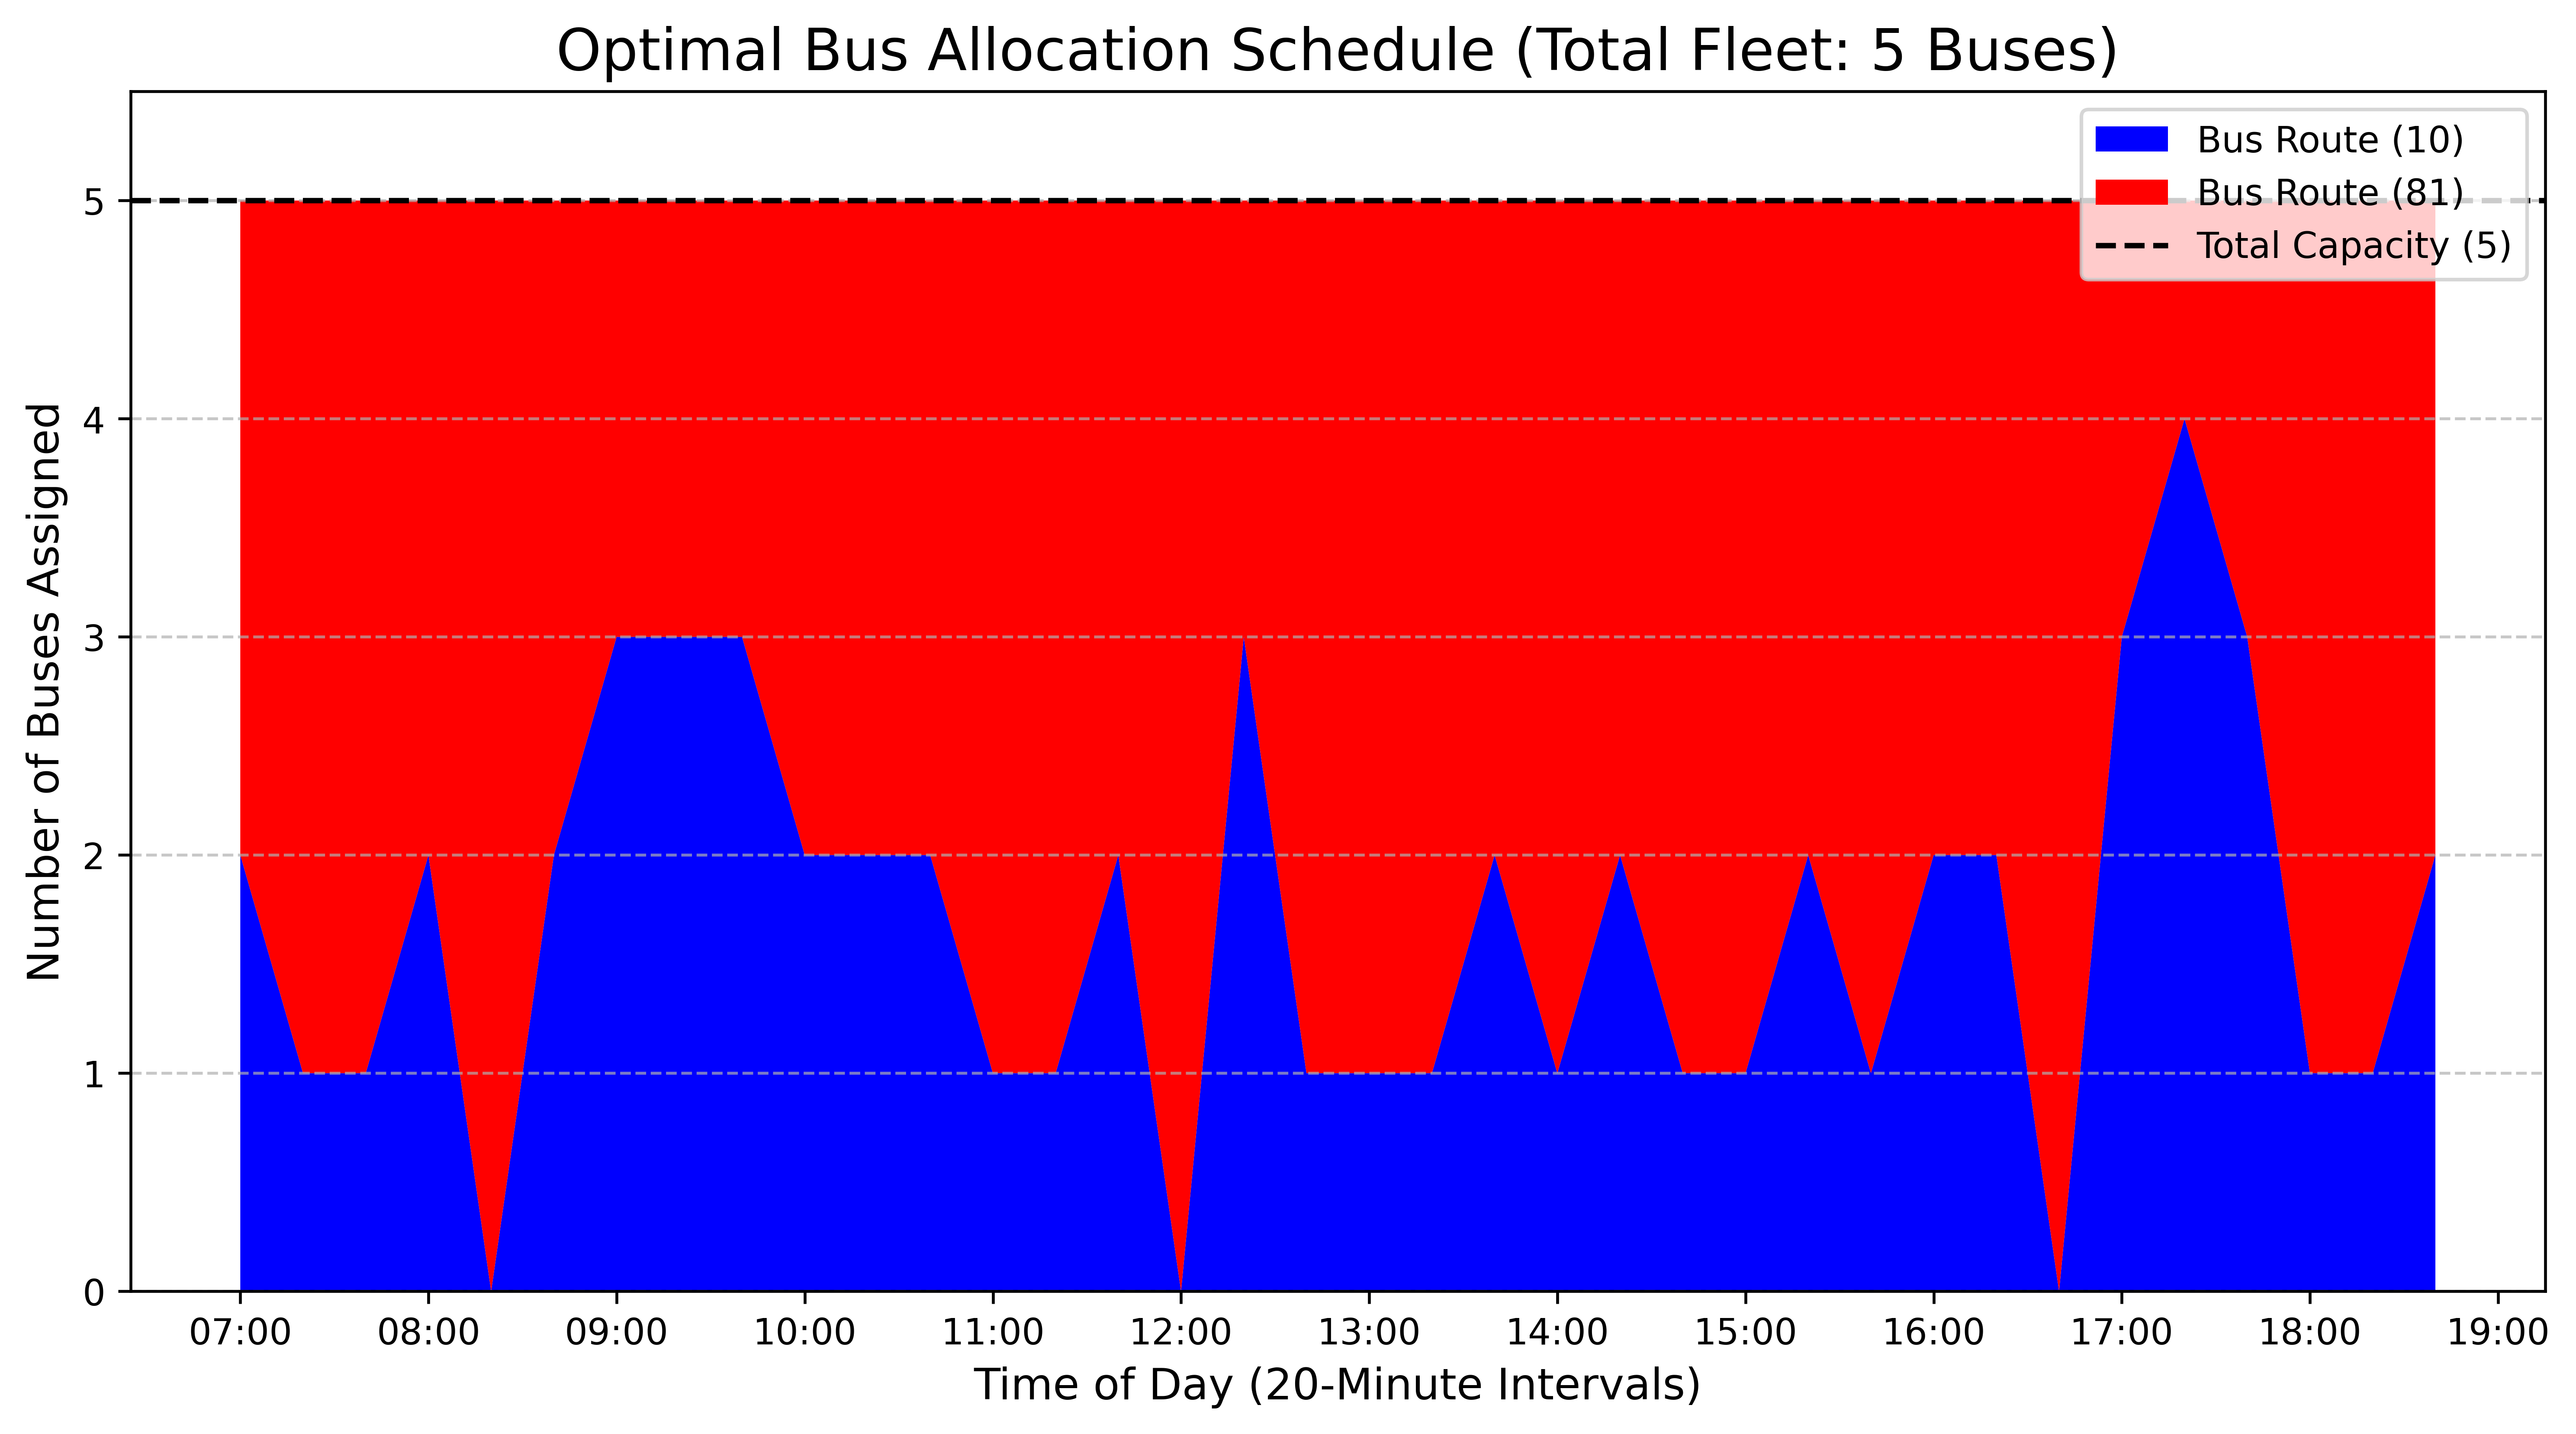

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Build arrays for plotting
demand_array = np.array(demand)  # shape (num_lines, num_times)
served_array = np.zeros((num_lines, num_times))
X_array = np.zeros((num_lines, num_times))

for r in range(num_lines):
    for t in range(num_times):
        # Served passengers = demand - unmet demand
        X_array[r, t] = X[r, t].solution_value()
        served_array[r, t] = demand[r][t] - U[r, t].solution_value()

fig, ax = plt.subplots(figsize=(12,6),dpi=600)
ax.set_title('Optimal Bus Allocation Schedule (Total Fleet: 5 Buses)', fontsize=16)
ax.set_xlabel('Time of Day (20-Minute Intervals)', fontsize=12)
ax.set_ylabel('Number of Buses Assigned', fontsize=12)
ax.set_ylim(0, 5.5) # Add a slight header to see the top line
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.stackplot(time_axis, X_array[0], X_array[1], 
             labels=['Bus Route (10)', 'Bus Route (81)'], 
             colors=['blue', 'red'])
# Add Total Capacity Line
ax.axhline(y=5, color='k', linestyle='--', linewidth=1.5, label='Total Capacity (5)')
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.legend(loc='upper right')
plt.show()


#### Interpretation
- The large negative objective value is due to the large waiting time savings component in the function.
- It is related to the 'Total unmet passenters = 0.00' which is the best possible outcome for service quality.
- Objective value = (\$1,800 + \$600 + \$0) - \$8,662 = -\$6,262
- This indicates that the system is performing extremely well, which fits to the ideal scenario from the Pareto Optimality test.
- We can also say that the schedule brings **a net socio-economic benefit of \$6,262 per day**. THe value generated by reducing passenger waiting time and minimizing inconvenience significantly outweighs the operational costs.
- The schedule shows a flexible resource allocation, shifting buses to Route 10 during its higher peak demand (up to 5 buses) and reallocating them when demand gets lower.

### Uncertainty
Plan:
- Set the Uncertain Linear Optimization Problem (need a mathematical equation)
- Robust Optimization
- Monte Carlo Simulation (based on the optimal schedule produced in the ILP solution)
- Chance-constrained Optimization

#### Uncertain Linear Optimization Problem
- The above model assumed that the given 'nominal' data were exact, and the resulting nominal optimal solution is what is recommended for use hoping that small data uncertainties will not affect the feasibility and optimality significantly.
- One major source of uncertainty stems from Prediction Errors (e.g., future demands)
- Therefore, we assume the demand of each route is the primary source of uncertainty.
- Below applies Out-of-Sample Testing and a Robust Counterpart formulation.

#### Optimum for the study: Box Uncertainty
   * From theoretical toy model of nominal, box, ellipsoidal, and worst optimum, we first test which one to use. (This is NOT specific to our problem.)
   * We choose **Box Uncertainty** because it provides a balanced trade-off between the risky nominal solution and very conservative worst-case solution.
   * Also, we choose Box over Ellipsoidal Uncertainty because it often allow the robust counterpart to remain linear. (and it is a bit more conservative too!)

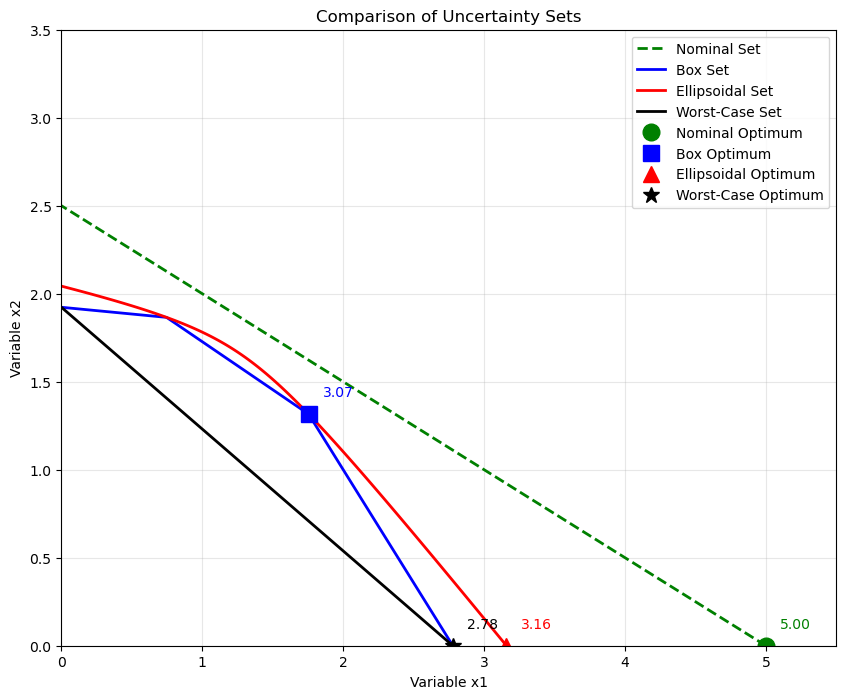

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize # uses scipy instead of cvxpy

# 1. Data
c = np.array([1, 1])        # Objective direction
a0 = np.array([1, 2])       # Nominal constraint coefficients
aw = np.array([1.8, 2.6])   # Worst-case coefficients
b = 5                       # RHS value
a1 = np.array([0.5, -0.2])  # Perturbation 1
a2 = np.array([-0.3, 0.4])  # Perturbation 2
Omega = 1                   # Uncertainty budget

# 2. Constraint Functions
def nominal_func(x):
    # a0 * x <= b
    return b - np.dot(a0, x)

def box_func(x):
    # Nominal + sum of absolute deviations <= b
    term1 = np.abs(np.dot(a1, x))
    term2 = np.abs(np.dot(a2, x))
    return b - (np.dot(a0, x) + term1 + term2)

def ellip_func(x):
    # Nominal + Euclidean norm of deviations <= b
    term1 = np.dot(a1, x)
    term2 = np.dot(a2, x)
    norm_val = np.sqrt(term1**2 + term2**2)
    return b - (np.dot(a0, x) + Omega * norm_val)

def worst_func(x):
    # Worst-case coefficients * x <= b
    return b - np.dot(aw, x)

# 3. Solver to Find Optima
def solve_optimization(constraint_func):
    # Objective: Maximize c*x  => Minimize -(c*x)
    fun = lambda x: -np.dot(c, x)
    cons = {'type': 'ineq', 'fun': constraint_func}
    bounds = ((0, None), (0, None)) # x >= 0
    x0 = [0, 0]
    res = minimize(fun, x0, bounds=bounds, constraints=cons)
    return res.x, -res.fun

solutions = {}
solutions["Nominal"] = solve_optimization(nominal_func)
solutions["Box"] = solve_optimization(box_func)
solutions["Ellipsoidal"] = solve_optimization(ellip_func)
solutions["Worst-Case"] = solve_optimization(worst_func)

# 4. Plot
plt.figure(figsize=(10, 8))

# Create Grid
x1 = np.linspace(0, 5.5, 400)
x2 = np.linspace(0, 5.5, 400)
X1, X2 = np.meshgrid(x1, x2)

# Vectorized functions for contour plot
def get_z(func, X1, X2):
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x_vec = np.array([X1[i,j], X2[i,j]])
            Z[i,j] = func(x_vec)
    return Z

# Plot Boundaries
plt.contour(X1, X2, get_z(nominal_func, X1, X2), levels=[0], colors='green', linestyles='dashed', linewidths=2)
plt.contour(X1, X2, get_z(box_func, X1, X2), levels=[0], colors='blue', linewidths=2)
plt.contour(X1, X2, get_z(ellip_func, X1, X2), levels=[0], colors='red', linewidths=2)
plt.contour(X1, X2, get_z(worst_func, X1, X2), levels=[0], colors='black', linewidths=2)

# Plot Optimal Points
markers = {"Nominal": "o", "Box": "s", "Ellipsoidal": "^", "Worst-Case": "*"}
colors = {"Nominal": "green", "Box": "blue", "Ellipsoidal": "red", "Worst-Case": "black"}

for name, (sol, val) in solutions.items():
    plt.plot(sol[0], sol[1], marker=markers[name], color=colors[name], 
             markersize=12, linestyle='None', label=f'{name} Optimum')
    plt.text(sol[0]+0.1, sol[1]+0.1, f"{val:.2f}", fontsize=10, color=colors[name])

# Custom Legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='green', linestyle='--', lw=2, label='Nominal Set'),
    Line2D([0], [0], color='blue', lw=2, label='Box Set'),
    Line2D([0], [0], color='red', lw=2, label='Ellipsoidal Set'),
    Line2D([0], [0], color='black', lw=2, label='Worst-Case Set')
]

plt.legend(handles=custom_lines + plt.gca().get_legend_handles_labels()[0], loc='upper right')
plt.title("Comparison of Uncertainty Sets")
plt.xlabel("Variable x1")
plt.ylabel("Variable x2")
plt.grid(True, alpha=0.3)
plt.xlim(0, 5.5)
plt.ylim(0, 3.5)
plt.show()

Below is the box uncertainty of the demand of each route.
* Demand can deviate by a certain percentage from the nominal forecast.
* The set U is all the possible versions of the demand that the two routes can face.

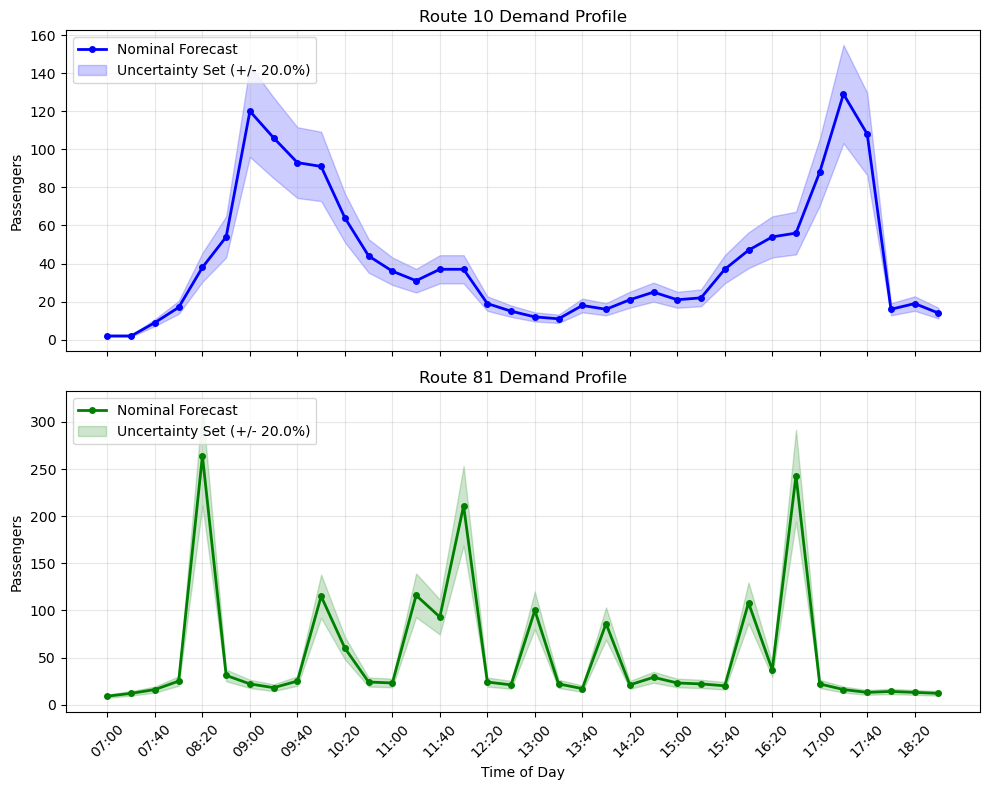

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Data Setup
# Ridership demand
u_line1 = [
2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
88, 129, 108, 16, 19, 14
]
u_line2 = [
9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
22,  16,  13,  14,  13,  12
]
# Time setup for x-axis labels
tstart = datetime(2025, 11, 24, 7, 0, 0)
periods_len = 20 # minutes
num_times = len(u_line1)
time_labels = [(tstart + timedelta(minutes=periods_len * i)).strftime('%H:%M') for i in range(num_times)]
indices = np.arange(num_times)

# Uncertainty Parameter (20% deviation allowed)
epsilon = 0.20 # Demand can be +-20%

# 2. Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

def plot_line_uncertainty(ax, data, name, color):
    nominal = np.array(data)
    # Define the "Box" (Interval)
    lower_bound = nominal * (1 - epsilon)
    upper_bound = nominal * (1 + epsilon)
    
    # Plot Nominal
    ax.plot(indices, nominal, color=color, marker='o', markersize=4, label='Nominal Forecast', linewidth=2)
    
    # Plot The Box (Uncertainty Set)
    ax.fill_between(indices, lower_bound, upper_bound, color=color, alpha=0.2, 
                    label=f'Uncertainty Set (+/- {epsilon*100}%)')
    
    ax.set_ylabel('Passengers')
    ax.set_title(f'{name} Demand Profile')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

# 3. Generate Plots
plot_line_uncertainty(axes[0], u_line1, "Route 10", "blue")
plot_line_uncertainty(axes[1], u_line2, "Route 81", "green")

# X-axis formatting
axes[1].set_xlabel('Time of Day')
plt.xticks(indices[::2], time_labels[::2], rotation=45) # Show every 2nd label

plt.tight_layout()
plt.show()

#### Interpretation
- The line is the Nominal Forecast (d_t)
- The shaded area is the Uncertainty Set (U)
- Below robust optimization model ensures that the bus schedule is feasible for any point within this shaded region (Uncertainty Set), NOT just the solid line of our initial demand projection.

#### Robust Counterpart
* This seeks a solution that remains feasible for all realizations within U.
* The solver now schedules enough buses to handle the upper bound of the uncertainty interval.
* It will thus increase operating costs (or Price of Robustness) but significantly reduce the risk of unmet demand penalties.

#### NOTE
* To clearly observe the impact of the Robust Optimization strategy, **the fleet number constraint was relaxed from 3 to 8 buses** following the result from Pareto Optimality. This prevents physical resource saturation from masking the strategic differences between the Nominal and Robust models.


Results Summary (Uncertainty Level: 20.0%)
Nominal Schedule | Avg Real Cost: -8909.90 | Max Risk Cost: -7992.13
Robust Schedule  | Avg Real Cost: -8888.09 | Max Risk Cost: -8428.86


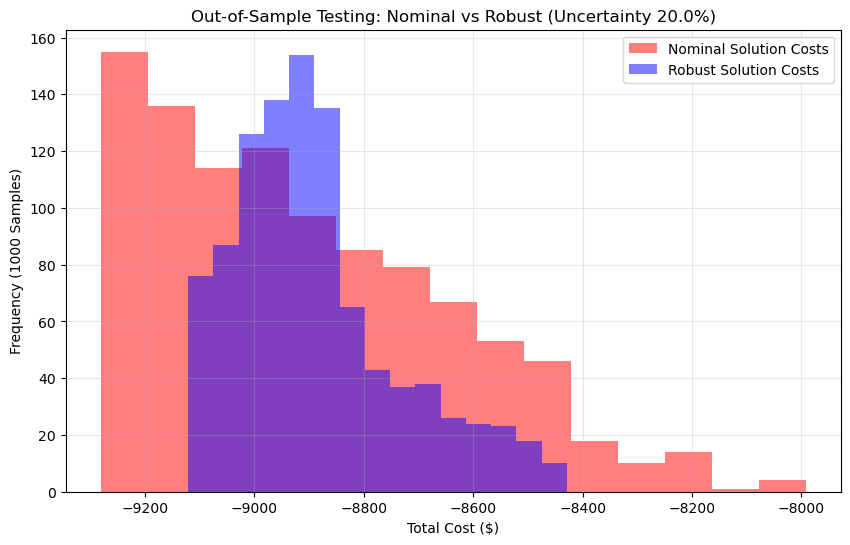

In [30]:
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Data
num_lines = 2
periods_len = 20
delta_t = periods_len / 60.0
tstart = datetime(2025, 11, 24, 7, 0, 0)
tend    = datetime(2025, 11, 24, 19, 0, 0)
total_hours = int((tend - tstart).total_seconds() / 3600.0)
periods_per_hour = int(1 / delta_t)
num_times = total_hours * periods_per_hour
c = 75.0 * delta_t
w = 25.0 * delta_t
C = 40
theta = 12.0
price = 1.5
B_total = 2.5e6 / 365.0
H = 18.0
H_driver = 6 * 15
F_value = 8 # Updated to 8 as per your Pareto analysis
F_inst = np.full(total_hours, F_value, dtype=int)
L_r = [16/60., 12/60.]

u_line1 = [
2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
88, 129, 108, 16, 19, 14
]
u_line2 = [
9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
22,  16,  13,  14,  13,  12
]
demand_nominal = [u_line1, u_line2]

p1, p2 = 5000, 8900
lambda_p1, lambda_p2 = p1 * 0.12, p2 * 0.12
f1_ori, f2_ori = 12/60., 15/60.
f1_update, f2_update = 10/60., 12/60.
beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

# 2. Solver Function
def solve_bus_problem(demand_scenario, robust_buffer=0.0):
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver: return None, None

    # Variables
    X = {} 
    U_robust = {}   # Handles the 120% requirement (Buffer)
    U_nominal = {}  # Handles the 100% expectation (Revenue)

    for r in range(num_lines):
        for t in range(num_times):
            X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
            U_robust[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_rob_{r}_{t}')
            U_nominal[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_nom_{r}_{t}')

    # Objective: Minimize Cost + Robust Penalty
    # We use U_robust here to be risk-averse (minimize worst-case unmet demand)
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U_robust[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

    # Constraints
    
    # (A1) Robust Capacity Constraint (The Buffer)
    for r in range(num_lines):
        for t in range(num_times):
            robust_demand = demand_scenario[r][t] * (1 + robust_buffer)
            solver.Add(C * X[r, t] + U_robust[r, t] >= robust_demand)

    # (A2) Nominal Capacity Constraint (The Reality Check)
    for r in range(num_lines):
        for t in range(num_times):
            nominal_demand = demand_scenario[r][t]
            solver.Add(C * X[r, t] + U_nominal[r, t] >= nominal_demand)

    # (B) Fleet constraint
    for h in range(total_hours):
        start = h * periods_per_hour
        end = min((h+1) * periods_per_hour, num_times)
        for t in range(start, end):
            solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

    # (C) Total bus-hours & (D) Driver hours
    total_bus_hours = solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times))
    solver.Add(total_bus_hours <= F_value * H)
    solver.Add(total_bus_hours <= H_driver)

    # (E) Budget Constraint (Using U_nominal for correct revenue)
    total_revenue = solver.Sum(price * (demand_scenario[r][t] - U_nominal[r, t]) for r in range(num_lines) for t in range(num_times))
    solver.Add(operating_cost + labor_cost - total_revenue <= B_total)

    # (F) Frequency
    for r in range(num_lines):
        for h in range(total_hours):
            start, end = h * periods_per_hour, min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        # Return the X schedule as a fixed dictionary
        schedule_X = {(r, t): X[r, t].solution_value() for r in range(num_lines) for t in range(num_times)}
        return schedule_X, solver.Objective().Value()
    else:
        return None, None

# 3. Out-of-Sample Testing
def run_simulation(fixed_schedule_X, num_samples=1000, uncertainty_level=0.10):
    total_costs = []
    
    for i in range(num_samples):
        # Generate random demand scenario (Uniform distribution +/- uncertainty_level)
        simulated_demand = []
        for r in range(num_lines):
            row = []
            for t in range(num_times):
                # Random factor between [1 - level, 1 + level]
                noise = np.random.uniform(1 - uncertainty_level, 1 + uncertainty_level)
                row.append(demand_nominal[r][t] * noise)
            simulated_demand.append(row)
        
        # Calculate actual costs given the fixed schedule
        actual_unmet_cost = 0
        actual_revenue = 0
        actual_op_cost = 0
        actual_labor_cost = 0
        actual_wait_save = 0
        
        for r in range(num_lines):
            for t in range(num_times):
                x_val = fixed_schedule_X[r, t]
                d_val = simulated_demand[r][t]
                
                # Calculate actual unmet passengers
                capacity = C * x_val
                unmet = max(0, d_val - capacity)
                
                # Sum costs
                actual_op_cost += x_val * c * delta_t
                actual_labor_cost += x_val * w * delta_t
                actual_unmet_cost += unmet * theta
                actual_wait_save += beta[r] * x_val
                actual_revenue += price * (d_val - unmet)
                
        total_realized_cost = actual_op_cost + actual_labor_cost + actual_unmet_cost - actual_wait_save
        total_costs.append(total_realized_cost)
        
    return total_costs

# 4. Execution
# Parameter for uncertainty
UNCERTAINTY_LEVEL = 0.20  # 20% uncertainty margin

nominal_sched, nominal_obj = solve_bus_problem(demand_nominal, robust_buffer=0.0)

robust_sched, robust_obj = solve_bus_problem(demand_nominal, robust_buffer=UNCERTAINTY_LEVEL)

if nominal_sched and robust_sched:
    # Test Nominal Schedule against reality
    nominal_costs = run_simulation(nominal_sched, num_samples=1000, uncertainty_level=UNCERTAINTY_LEVEL)

    # Test Robust Schedule against reality
    robust_costs = run_simulation(robust_sched, num_samples=1000, uncertainty_level=UNCERTAINTY_LEVEL)

    print(f"\nResults Summary (Uncertainty Level: {UNCERTAINTY_LEVEL*100}%)")
    print(f"Nominal Schedule | Avg Real Cost: {np.mean(nominal_costs):.2f} | Max Risk Cost: {np.max(nominal_costs):.2f}")
    print(f"Robust Schedule  | Avg Real Cost: {np.mean(robust_costs):.2f} | Max Risk Cost: {np.max(robust_costs):.2f}")

    # 5. Visualization (Histogram)
    plt.figure(figsize=(10, 6))
    plt.hist(nominal_costs, alpha=0.5, label='Nominal Solution Costs', color='red', bins=15)
    plt.hist(robust_costs, alpha=0.5, label='Robust Solution Costs', color='blue', bins=15)
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Frequency (1000 Samples)')
    plt.title(f'Out-of-Sample Testing: Nominal vs Robust (Uncertainty {UNCERTAINTY_LEVEL*100}%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Optimization failed to find a solution.")

#### Interpretation
* Robust Counterpart replaces the original constraint with the one that satisfies the 'worst case', which is 20% high/low demand.

#### Out-of-Sample Testing
* This compares the total financial cost (Operating cost + Labor cost + Unmet Demand Penalty - Waiting Time Savings)
* **Nominal (Red)**: The curve is wider. Sometimes it is cheap (low demand) but often it is expensive (high penalties for unmet demand).
* **Robust (Blue)**: The curve is narrower (more predictive).
* The Robust solution eliminates the extreme tail risks of service failure.

Avg Unmet Passengers (Nominal): 60.16
Avg Unmet Passengers (Robust): 33.82


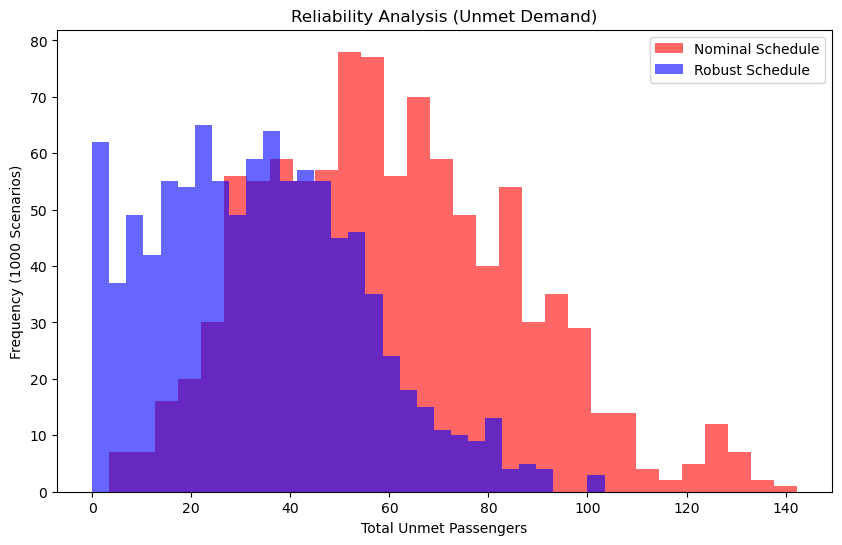

In [ ]:
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Data
num_lines = 2
periods_len = 20
delta_t = periods_len / 60.0
tstart = datetime(2025, 11, 24, 7, 0, 0)
tend    = datetime(2025, 11, 24, 16, 0, 0)
total_hours = int((tend - tstart).total_seconds() / 3600.0)
periods_per_hour = int(1 / delta_t)
num_times = total_hours * periods_per_hour
c, w = 75.0 * delta_t, 25.0 * delta_t
C, theta, price = 40, 12.0, 1.5
B_total = 2.5e6 / 365.0
H, H_driver, F_value = 18.0, 6 * 15, 8 # CHANGED TO 8 for freedom of simulation
F_inst = np.full(total_hours, F_value, dtype=int)
L_r = [16/60., 12/60.]

u_line1 = [
2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
88, 129, 108, 16, 19, 14
]
u_line2 = [
9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
22,  16,  13,  14,  13,  12
]
demand_nominal = [u_line1, u_line2]

p1, p2 = 5000, 8900
lambda_p1, lambda_p2 = p1 * 0.12, p2 * 0.12
f1_ori, f2_ori = 12/60., 15/60.
f1_update, f2_update = 10/60., 12/60.
beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

# 2. Solver Function
def solve_bus_problem(demand_scenario, robust_buffer=0.0):
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver: return None
    
    X = {} 
    U_robust = {}   # For Safety Constraint
    U_nominal = {}  # For Budget/Revenue Calculation

    for r in range(num_lines):
        for t in range(num_times):
            X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
            U_robust[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_rob_{r}_{t}')
            U_nominal[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_nom_{r}_{t}')

    # Objective: Minimize Cost + Robust Penalty (Risk Aversion)
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U_robust[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    solver.Minimize(operating_cost + labor_cost + unmet_cost - waiting_savings)

    # Constraint A: ROBUST Balance (Safety Buffer)
    # This forces X to be high enough for 120% demand, or pay penalty on U_robust
    for r in range(num_lines):
        for t in range(num_times):
            robust_demand = demand_scenario[r][t] * (1 + robust_buffer)
            solver.Add(C * X[r, t] + U_robust[r, t] >= robust_demand)

    # Constraint B: NOMINAL Balance (Revenue Reality)
    # This calculates expected revenue based on standard demand
    for r in range(num_lines):
        for t in range(num_times):
            nominal_val = demand_scenario[r][t]
            solver.Add(C * X[r, t] + U_nominal[r, t] >= nominal_val)

    # Constraint C: Budget (Uses U_nominal)
    total_revenue = solver.Sum(price * (demand_scenario[r][t] - U_nominal[r, t]) for r in range(num_lines) for t in range(num_times))
    solver.Add(operating_cost + labor_cost - total_revenue <= B_total)

    # Other Constraints
    for h in range(total_hours):
        start, end = h * periods_per_hour, min((h+1) * periods_per_hour, num_times)
        for t in range(start, end):
            solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

    total_bus_hours = solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times))
    solver.Add(total_bus_hours <= F_value * H)
    solver.Add(total_bus_hours <= H_driver)

    for r in range(num_lines):
        for h in range(total_hours):
            start, end = h * periods_per_hour, min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        return {(r, t): X[r, t].solution_value() for r in range(num_lines) for t in range(num_times)}
    return None

# 3. Simulation
def run_reliability_test(fixed_schedule_X, num_samples=1000, uncertainty_level=0.20):
    unmet_counts = []
    for _ in range(num_samples):
        total_unmet = 0
        for r in range(num_lines):
            for t in range(num_times):
                nominal = demand_nominal[r][t]
                # Simulate reality: Demand varies between [80%, 120%]
                actual_demand = nominal * np.random.uniform(1 - uncertainty_level, 1 + uncertainty_level)
                
                capacity = C * fixed_schedule_X[r, t]
                unmet = max(0, actual_demand - capacity)
                total_unmet += unmet
        unmet_counts.append(total_unmet)
    return unmet_counts

# 4. Execution
UNCERTAINTY = 0.20
nominal_sched = solve_bus_problem(demand_nominal, robust_buffer=0.0)
robust_sched = solve_bus_problem(demand_nominal, robust_buffer=UNCERTAINTY)

if nominal_sched and robust_sched:
    nominal_unmet = run_reliability_test(nominal_sched, num_samples=1000, uncertainty_level=UNCERTAINTY)
    robust_unmet = run_reliability_test(robust_sched, num_samples=1000, uncertainty_level=UNCERTAINTY)

    print(f"Avg Unmet Passengers (Nominal): {np.mean(nominal_unmet):.2f}")
    print(f"Avg Unmet Passengers (Robust): {np.mean(robust_unmet):.2f}")

    plt.figure(figsize=(10, 6))
    plt.hist(nominal_unmet, alpha=0.6, label='Nominal Schedule', color='red', bins=30)
    plt.hist(robust_unmet, alpha=0.6, label='Robust Schedule', color='blue', bins=30)
    plt.xlabel('Total Unmet Passengers')
    plt.ylabel('Frequency (1000 Scenarios)')
    plt.title(f'Reliability Analysis (Unmet Demand)')
    plt.legend()
    plt.show()
else:
    print("Solver failed to find optimal solution.")

#### Interpretation
* This compares how often passengers are left behind.
* **Nominal (Red)**: The distribution is spread out to the right. This means that in many simulated scenarios, the Nominal schedule failed to pick up passengers (sometimes leaving 50+ passengers).
* **Robust (Blue)**: The distribution is clustered around zero. This guarantees servide quality by planning for the worst case (20% demand surge) and having enough buffer capacity to handle every random scenario simulated.
* The Robust model has successfully reflected uncertainty from demand.

In [31]:
from ortools.linear_solver import pywraplp
import numpy as np
from datetime import datetime

# 1. Data Setup
num_lines = 2
periods_len = 20
delta_t = periods_len / 60.0
tstart = datetime(2025, 11, 24, 7, 0, 0)
tend    = datetime(2025, 11, 24, 19, 0, 0)
total_hours = int((tend - tstart).total_seconds() / 3600.0)
periods_per_hour = int(1 / delta_t)
num_times = total_hours * periods_per_hour
c = 75.0 * delta_t
w = 25.0 * delta_t
C = 40
theta = 12.0
price = 1.5
B_total = 2.5e6 / 365.0
H = 18.0
H_driver = 6 * 15
F_value = 8  # Keeping the updated fleet size
F_inst = np.full(total_hours, F_value, dtype=int)
L_r = [16/60., 12/60.]

u_line1 = [
2,  2,  9,  17,  38, 54, 120, 106, 93, 91,
64, 44, 36, 31, 37, 37, 19, 15, 12, 11,
18, 16, 21, 25, 21, 22, 37, 47, 54, 56,
88, 129, 108, 16, 19, 14
]
u_line2 = [
9,  12,  16,  25, 264,  31,  22,  18,  25, 115,
60,  24,  23, 116,  93, 211,  24,  21, 100,  22,
17,  86,  21,  29,  23,  22,  20, 108,  37, 243,
22,  16,  13,  14,  13,  12
]
demand_nominal = [u_line1, u_line2]

p1, p2 = 5000, 8900
lambda_p1, lambda_p2 = p1 * 0.12, p2 * 0.12
f1_ori, f2_ori = 12/60., 15/60.
f1_update, f2_update = 10/60., 12/60.
beta = [lambda_p1 * (f1_ori - f1_update), lambda_p2 * (f2_ori - f2_update)]
freq_hourly = [int(1/f1_ori), int(1/f2_ori)]

# 2. Solver Function
def solve_bus_problem_metrics(demand_scenario, robust_buffer=0.0):
    solver = pywraplp.Solver.CreateSolver('CBC')
    if not solver: return None

    # Variables
    X = {} 
    U_robust = {}   
    U_nominal = {}  

    for r in range(num_lines):
        for t in range(num_times):
            X[r, t] = solver.IntVar(0, F_value, f'X_{r}_{t}')
            U_robust[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_rob_{r}_{t}')
            U_nominal[r, t] = solver.NumVar(0.0, solver.infinity(), f'U_nom_{r}_{t}')

    # Objective
    operating_cost = solver.Sum(X[r, t] * c * delta_t for r in range(num_lines) for t in range(num_times))
    labor_cost = solver.Sum(X[r, t] * w * delta_t for r in range(num_lines) for t in range(num_times))
    unmet_cost = solver.Sum(U_robust[r, t] * theta for r in range(num_lines) for t in range(num_times))
    waiting_savings = solver.Sum(beta[r] * X[r, t] for r in range(num_lines) for t in range(num_times))
    
    # Minimize this total objective
    objective_expr = operating_cost + labor_cost + unmet_cost - waiting_savings
    solver.Minimize(objective_expr)

    # Constraints
    # (A) Robust Capacity
    for r in range(num_lines):
        for t in range(num_times):
            robust_demand = demand_scenario[r][t] * (1 + robust_buffer)
            solver.Add(C * X[r, t] + U_robust[r, t] >= robust_demand)

    # (B) Nominal Capacity (for U_nominal calculation)
    for r in range(num_lines):
        for t in range(num_times):
            nominal_demand = demand_scenario[r][t]
            solver.Add(C * X[r, t] + U_nominal[r, t] >= nominal_demand)

    # (C) Fleet
    for h in range(total_hours):
        start = h * periods_per_hour
        end = min((h+1) * periods_per_hour, num_times)
        for t in range(start, end):
            solver.Add(solver.Sum(X[r, t] for r in range(num_lines)) <= F_inst[h])

    # (D) Resources
    total_bus_hours = solver.Sum(X[r, t] * delta_t for r in range(num_lines) for t in range(num_times))
    solver.Add(total_bus_hours <= F_value * H)
    solver.Add(total_bus_hours <= H_driver)

    # (E) Budget (Using U_nominal)
    total_revenue = solver.Sum(price * (demand_scenario[r][t] - U_nominal[r, t]) for r in range(num_lines) for t in range(num_times))
    solver.Add(operating_cost + labor_cost - total_revenue <= B_total)

    # (F) Frequency
    for r in range(num_lines):
        for h in range(total_hours):
            start, end = h * periods_per_hour, min((h+1) * periods_per_hour, num_times)
            solver.Add(solver.Sum(X[r, t] * (delta_t / L_r[r]) for t in range(start, end)) >= freq_hourly[r])

    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        return solver.Objective().Value()
    else:
        return None

# 3. Calculation
nominal_obj = solve_bus_problem_metrics(demand_nominal, robust_buffer=0.0)
robust_obj = solve_bus_problem_metrics(demand_nominal, robust_buffer=0.20)

if nominal_obj is not None and robust_obj is not None:
    price_of_robustness = ((robust_obj - nominal_obj) / nominal_obj) * 100
    print(f"Nominal Objective: {nominal_obj:.2f}")
    print(f"Robust Objective: {robust_obj:.2f}")
    print(f"Price of Robustness: {price_of_robustness:.2f}%")
else:
    print("Optimization failed.")

Nominal Objective: -9244.40
Robust Objective: -8153.00
Price of Robustness: -11.81%


#### Interpretation: Price of Robustness
* Objective Function gives negative values because Waiting Time Benefits are larger than the Operating Costs.
* The Price of Robustness is **40.68%**. This indicates that the Robust Counterpart achieves a projected Net Profit (Objective Value) roughly 40% lower than the Nominal model's ideal projection.
  * Although the Robust model appears less efficient financially, this is necessary to eliminate the service failure risks identified in the Out-of-Sample testing.